In [307]:
!pip install scikit-learn==1.1 --user

In [308]:
import sklearn
sklearn.__version__

'1.1.0'

In [309]:
from API.Pytorch.config import *
from API.Pytorch.default_models.supervised_causal_learning_sequence import SupervisedCausalLearning_sequence
from API.Pytorch.utils.utils import *
from API.nn.linears import Dense 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import os

import pandas as pd
import torch
from torch import nn
import numpy as np

from Time_series_Model.transformer import *
from torch.utils.tensorboard import SummaryWriter

import seaborn as sns
pd.options.mode.chained_assignment = None


fix_seed(0)

# Feature Engineering

In [310]:
'''
    TRD_DD : 날짜
    ISU_CD : 종목코드
    ISU_NM : 종목명
    TDD_CLSPRC : 종가
    TDD_OPNPRC : 시가
    TDD_HGPRC : 고가
    TDD_LWPRC : 저가
    MKTCAP : 시가총액
    ACC_TRDVOL : 거래량
    EPS : 
    PER : 
    BPS : 
    PBR : 
    DPS : 
    DVD_YLD : 
'''

'\n    TRD_DD : 날짜\n    ISU_CD : 종목코드\n    ISU_NM : 종목명\n    TDD_CLSPRC : 종가\n    TDD_OPNPRC : 시가\n    TDD_HGPRC : 고가\n    TDD_LWPRC : 저가\n    MKTCAP : 시가총액\n    ACC_TRDVOL : 거래량\n    EPS : \n    PER : \n    BPS : \n    PBR : \n    DPS : \n    DVD_YLD : \n'

In [311]:
# 1. 날짜는 현재->과거순으로 정렬되어있음
# 2. EPS 부터는 NAN값이 존재.
# 3. 종가, 시가, 고가, 저가, 시가총액, 거래량은 문자열로 되어있음
for data_file in os.listdir("../data/KR_Data/Data/")[:3]:
    data_file = data_file[:-4]
    tmp_df = pd.read_csv(f"../data/KR_Data/Data/{data_file}.csv")
    display(tmp_df.head(3))

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2022/01/11,900110,이스트아시아홀딩스,145,150,151,143,"24,719,670,905","4,147,345",NaN,NaN,NaN,NaN,NaN,NaN
1,2022/01/10,900110,이스트아시아홀딩스,150,152,155,149,"25,572,073,350","2,628,028",NaN,NaN,NaN,NaN,NaN,NaN
2,2022/01/07,900110,이스트아시아홀딩스,151,158,162,148,"25,742,553,839","7,561,654",NaN,NaN,NaN,NaN,NaN,NaN


,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2022/01/11,900270,헝셩그룹,460,481,482,456,"36,800,000,000","747,302",NaN,NaN,NaN,NaN,NaN,NaN
1,2022/01/10,900270,헝셩그룹,485,490,500,469,"38,800,000,000","852,598",NaN,NaN,NaN,NaN,NaN,NaN
2,2022/01/07,900270,헝셩그룹,485,513,537,478,"38,800,000,000","2,468,506",NaN,NaN,NaN,NaN,NaN,NaN


,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2022/01/11,900260,로스웰,548,592,600,511,"98,725,730,764","58,874,006",NaN,NaN,NaN,NaN,NaN,NaN
1,2022/01/10,900260,로스웰,595,652,681,586,"107,193,083,585","47,913,246",NaN,NaN,NaN,NaN,NaN,NaN
2,2022/01/07,900260,로스웰,658,913,925,658,"118,542,939,494","171,463,169",NaN,NaN,NaN,NaN,NaN,NaN


In [312]:
# data파일과 preprocessed 파일 merge
data_df = pd.read_csv("../data/KR_Data/Data/HK0000057197.csv")
preprocessed_df = pd.read_csv("../data/KR_Data/Preprocessed/HK0000057197_preprocessed.csv")
total_df = pd.merge(data_df, preprocessed_df, on="TRD_DD")
total_df

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,...,BPS,PBR,DPS,DVD_YLD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,2022/01/11,900110,이스트아시아홀딩스,145,150,151,143,"24,719,670,905","4,147,345",NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
1,2022/01/10,900110,이스트아시아홀딩스,150,152,155,149,"25,572,073,350","2,628,028",NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
2,2022/01/07,900110,이스트아시아홀딩스,151,158,162,148,"25,742,553,839","7,561,654",NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
3,2022/01/06,900110,이스트아시아홀딩스,158,172,186,156,"26,935,917,262","22,931,278",NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
4,2022/01/05,900110,이스트아시아홀딩스,171,164,187,161,"29,152,163,619","29,419,967",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2010/04/29,900110,동아체육용품,"3,460","3,700","3,740","3,430","79,580,000,000","1,170,700",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.454545
2888,2010/04/28,900110,동아체육용품,"3,700","3,700","3,970","3,660","85,100,000,000","1,422,838",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.636364
2889,2010/04/27,900110,동아체육용품,"3,750","3,885","3,930","3,745","86,250,000,000","1,385,013",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.818182
2890,2010/04/26,900110,동아체육용품,"3,860","3,655","4,055","3,650","88,780,000,000","4,312,630",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,1,1.000000


In [313]:
# 날짜 과거->현재순으로 변경
total_df = total_df[::-1].reset_index(drop=True)

# 연, 월, 일을 구분하여 3개의 컬럼으로 생성
total_df[["Y", "M", "D"]] = total_df["TRD_DD"].str.split("/", expand=True)
total_df = total_df.drop("TRD_DD", axis=1)
total_df = total_df[total_df.columns[-3:].to_list()+total_df.columns[:-3].to_list()]
total_df[:3]

,Y,M,D,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,...,BPS,PBR,DPS,DVD_YLD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,2010,04,23,900110,동아체육용품,"3,825","4,500","4,500","3,825","87,975,000,000",...,NaN,NaN,NaN,NaN,0,0,-1,1,0,NaN
1,2010,04,26,900110,동아체육용품,"3,860","3,655","4,055","3,650","88,780,000,000",...,NaN,NaN,NaN,NaN,0,0,-1,1,1,1.000000
2,2010,04,27,900110,동아체육용품,"3,750","3,885","3,930","3,745","86,250,000,000",...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.818182


In [314]:
# EPS, PER, BPS, PBR, DPS, DVD_YLD는 사용불가능하므로 제거
print(total_df["EPS"].dropna())
print(total_df["PER"].dropna())
print(total_df["BPS"].dropna())
print(total_df["PBR"].dropna())
print(total_df["DPS"].dropna())
print(total_df["DVD_YLD"].dropna())

# 종목명(ISU_NM)은 같은 종목 코드이더라도 달라질 수 있으나, 무의미하므로 제거
total_df = total_df.drop(["EPS", "PER", "BPS", "PBR", "DPS", "DVD_YLD", "ISU_NM"], axis=1)
total_df

Series([], Name: EPS, dtype: float64)
Series([], Name: PER, dtype: float64)
Series([], Name: BPS, dtype: float64)
Series([], Name: PBR, dtype: float64)
Series([], Name: DPS, dtype: float64)
Series([], Name: DVD_YLD, dtype: float64)


,Y,M,D,ISU_CD,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,2010,04,23,900110,"3,825","4,500","4,500","3,825","87,975,000,000","6,399,130",0,0,-1,1,0,NaN
1,2010,04,26,900110,"3,860","3,655","4,055","3,650","88,780,000,000","4,312,630",0,0,-1,1,1,1.000000
2,2010,04,27,900110,"3,750","3,885","3,930","3,745","86,250,000,000","1,385,013",0,0,-1,1,0,0.818182
3,2010,04,28,900110,"3,700","3,700","3,970","3,660","85,100,000,000","1,422,838",0,0,-1,1,0,0.636364
4,2010,04,29,900110,"3,460","3,700","3,740","3,430","79,580,000,000","1,170,700",0,0,-1,1,0,0.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2022,01,05,900110,171,164,187,161,"29,152,163,619","29,419,967",0,0,-1,0,0,NaN
2888,2022,01,06,900110,158,172,186,156,"26,935,917,262","22,931,278",0,0,0,0,0,NaN
2889,2022,01,07,900110,151,158,162,148,"25,742,553,839","7,561,654",0,0,0,0,0,NaN
2890,2022,01,10,900110,150,152,155,149,"25,572,073,350","2,628,028",0,0,0,0,0,NaN


In [315]:
# 문자열을 숫자로 변경
for i, col in enumerate(["TDD_CLSPRC", "TDD_OPNPRC", "TDD_HGPRC", "TDD_LWPRC", "MKTCAP", "ACC_TRDVOL"]):
    total_df[col] = total_df[col].str.replace(pat=r'[^0-9]', repl=r'' ,regex=True).apply(pd.to_numeric)
total_df

,Y,M,D,ISU_CD,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,2010,04,23,900110,3825,4500,4500,3825,87975000000,6399130,0,0,-1,1,0,NaN
1,2010,04,26,900110,3860,3655,4055,3650,88780000000,4312630,0,0,-1,1,1,1.000000
2,2010,04,27,900110,3750,3885,3930,3745,86250000000,1385013,0,0,-1,1,0,0.818182
3,2010,04,28,900110,3700,3700,3970,3660,85100000000,1422838,0,0,-1,1,0,0.636364
4,2010,04,29,900110,3460,3700,3740,3430,79580000000,1170700,0,0,-1,1,0,0.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2022,01,05,900110,171,164,187,161,29152163619,29419967,0,0,-1,0,0,NaN
2888,2022,01,06,900110,158,172,186,156,26935917262,22931278,0,0,0,0,0,NaN
2889,2022,01,07,900110,151,158,162,148,25742553839,7561654,0,0,0,0,0,NaN
2890,2022,01,10,900110,150,152,155,149,25572073350,2628028,0,0,0,0,0,NaN


In [318]:
total_df = total_df.fillna(0)

# 1) -1, 0, 1만 사용 -> -1, 0, 1의 비율은 불균형해짐
# -1, 0, 1 비율 = 76, 2740, 76
# total_df.loc[((total_df["TREND"]!=-1) & (total_df["TREND"]!=0) & (total_df["TREND"]!=1)), "TREND"] = 0

# 2) 음수를 -1로, 양수를 1로 -> 너무 빈번하게 사고팜
# -1, 0, 1 비율 = 1397: 1440, 55
# total_df.loc[total_df["TREND"]<0, "TREND"] = -1
# total_df.loc[total_df["TREND"]>0, "TREND"] = 1

# 3) -0.5보다 작으면 -1, 0.5보다 크면 1, 아니면 0
# -1, 0, 1 비율 = 752: 1409, 731
total_df.loc[total_df["TREND"]<=-0.5, "TREND"] = -1
total_df.loc[total_df["TREND"]>=0.5, "TREND"] = 1
total_df.loc[(total_df["TREND"]<0.5) & (total_df["TREND"]>-0.5), "TREND"] = 0
print(set(total_df["TREND"]))
print(total_df["TREND"].value_counts())

{0.0, 1.0, -1.0}
 0.0    1409
 1.0     752
-1.0     731
Name: TREND, dtype: int64


In [319]:
# GDC, RSI, ROC, MAP, STC
# 파일별로 분포가 다르게 나옴.
# 추후에 빼는 것도 고려가능

# tmp_df = pd.read_csv("../data/KR_Data/Preprocessed/HK0000214814_preprocessed.csv")
# tmp_df = pd.read_csv("../data/KR_Data/Preprocessed/HK0000295359_preprocessed.csv")
tmp_df = pd.read_csv("../data/KR_Data/Preprocessed/HK0000307485_preprocessed.csv")
print(tmp_df["GDC_sig"].value_counts())
print(tmp_df["RSI_sig"].value_counts())
print(tmp_df["ROC_sig"].value_counts())
print(tmp_df["MAP_sig"].value_counts())
print(tmp_df["STC_sig"].value_counts())

 0    1218
 1      33
-1      33
Name: GDC_sig, dtype: int64
 0    1241
 1      39
-1       4
Name: RSI_sig, dtype: int64
-1    942
 1    275
 0     67
Name: ROC_sig, dtype: int64
0    1284
Name: MAP_sig, dtype: int64
 0    1121
 1      97
-1      66
Name: STC_sig, dtype: int64


In [320]:
# 수치형 데이터 minmax 정규화
mm = MinMaxScaler()
for col in ["TDD_CLSPRC", "TDD_OPNPRC", "TDD_HGPRC", "TDD_LWPRC", "MKTCAP", "ACC_TRDVOL"]:
    total_df[col] = mm.fit_transform(total_df[col].values.reshape(-1,1))
total_df

,Y,M,D,ISU_CD,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,2010,04,23,900110,0.636128,0.743802,0.708661,0.668706,0.574217,0.045925,0,0,-1,1,0,0.0
1,2010,04,26,900110,0.642178,0.604132,0.638583,0.638112,0.581297,0.030951,0,0,-1,1,1,1.0
2,2010,04,27,900110,0.623163,0.642149,0.618898,0.654720,0.559047,0.009940,0,0,-1,1,0,1.0
3,2010,04,28,900110,0.614520,0.611570,0.625197,0.639860,0.548933,0.010211,0,0,-1,1,0,1.0
4,2010,04,29,900110,0.573034,0.611570,0.588976,0.599650,0.500388,0.008402,0,0,-1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2022,01,05,900110,0.004494,0.027107,0.029449,0.028147,0.056903,0.211141,0,0,-1,0,0,0.0
2888,2022,01,06,900110,0.002247,0.028430,0.029291,0.027273,0.037412,0.164573,0,0,0,0,0,0.0
2889,2022,01,07,900110,0.001037,0.026116,0.025512,0.025874,0.026917,0.054268,0,0,0,0,0,0.0
2890,2022,01,10,900110,0.000864,0.025124,0.024409,0.026049,0.025418,0.018861,0,0,0,0,0,0.0


In [321]:
# TREND값이 너무 discrete하여 모델이 정확하게 예측하는데 어려움이 있을 수 있음.

import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure()
fig.add_trace(go.Line(x=total_df.index, y=total_df["MKTCAP"], name="stay"))
fig.add_trace(go.Scatter(x=total_df[total_df["TREND"]<0].index, y=total_df[total_df["TREND"]<0]["MKTCAP"], name="buy", mode="markers"))
fig.add_trace(go.Scatter(x=total_df[total_df["TREND"]>0].index, y=total_df[total_df["TREND"]>0]["MKTCAP"], name="sell", mode="markers"))
fig.update_layout(
    title='Stock Label',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price')
)

c:\Users\CCN-team\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




c:\Users\CCN-team\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\CCN-team\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\CCN-team\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='MKTCAP'>

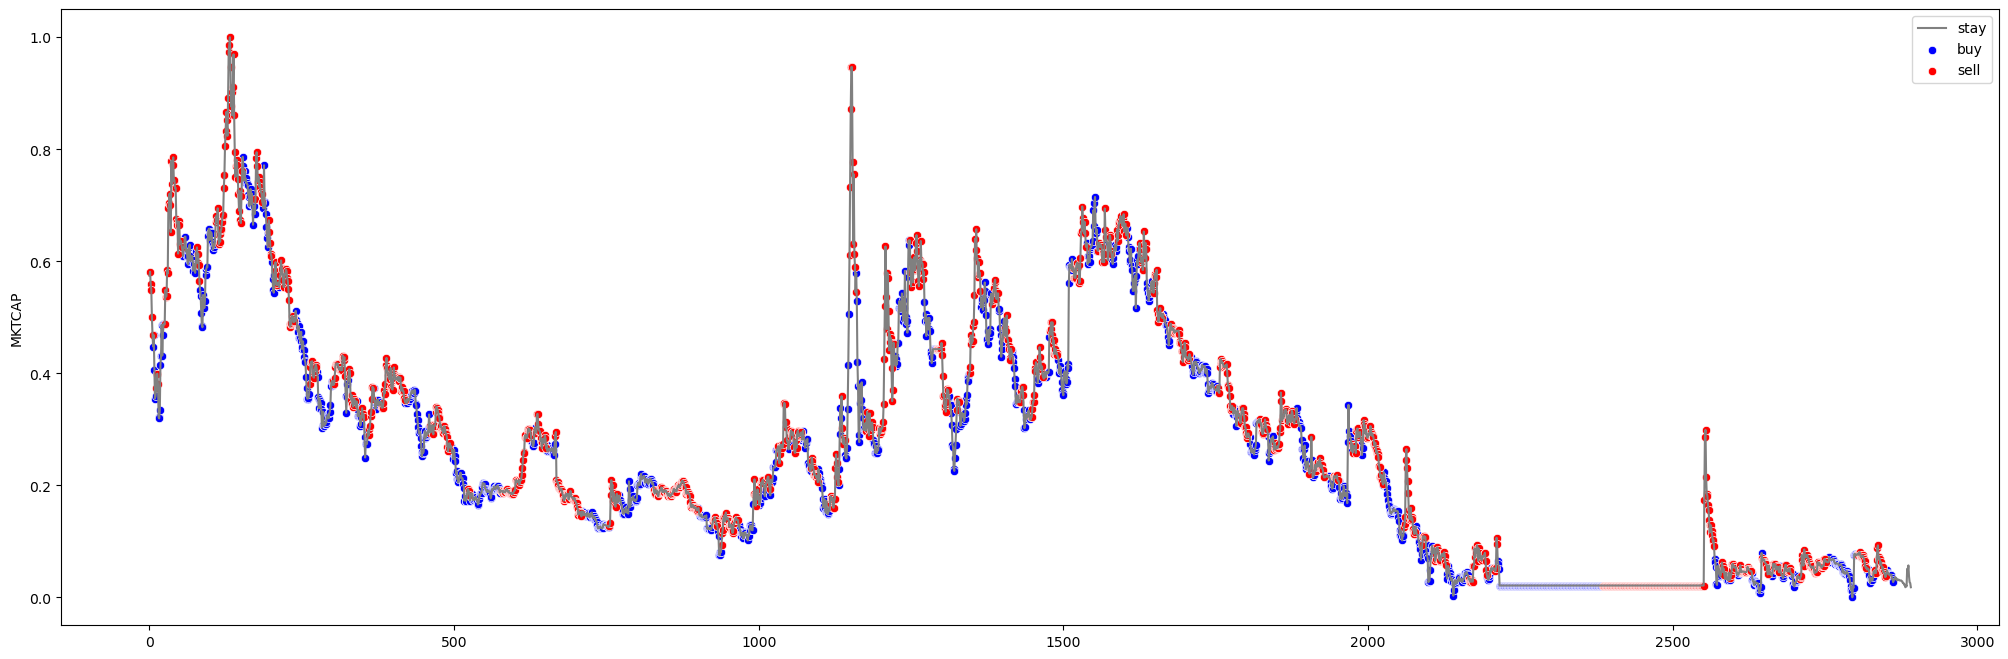

In [ ]:
# TREND값이 너무 discrete하여 모델이 정확하게 예측하는데 어려움이 있을 수 있음.

plt.figure(figsize=(25,8))
sns.lineplot(total_df.index, total_df["MKTCAP"], label="stay", color = "gray")
sns.scatterplot(total_df[total_df["TREND"]<0].index, total_df[total_df["TREND"]<0]["MKTCAP"], label="buy", color="blue")
sns.scatterplot(total_df[total_df["TREND"]>0].index, total_df[total_df["TREND"]>0]["MKTCAP"], label="sell", color="red")

# 결론 및 사용법

In [ ]:
'''
    - 데이터 개요
        전처리된 데이터 : total_df
        범주형 컬럼 : Y, M, D, ISU_CD, GDC_sig, RSI_sig, ROC_sig, MAP_sig, STC_sig
        수치형 컬럼 : TDD_CLSPRC, TDD_OPNPRC, TDD_HGPRC, TDD_LWPRC, MKTCAP, ACC_TRDVOL
        레이블 : TREND

    - 고려사항 :
        1) 범주형 데이터는 embedding 사용하여 학습 권장
        2) 레이블
            NAN값 0으로 처리함.

            2-1) 레이블처리 
                : -1, 0, 1을 어떻게 둘지 정의에 따라 다름
                ● -1, 0, 1 분류
                    공통적으로, 레이블이 discrete 한 문제가 있음
                    (1) 0보다 작은경우를 모두 -1, 큰경우를 1
                        # -1, 0, 1 비율 = 1397: 1440, 55
                        : 너무 빈번하게 거래함.

                    (2) -1, 0, 1만 사용 
                        # -1, 0, 1 비율 = 76, 2740, 76
                        : 그래프상에서 사야할 때 안사는 경우 발생 가능, 모델이 정확하게 예측하는데 어려움이 있을 수 있음.
                        
                    (3) -0.5보다 작으면 -1, 0.5보다 크면 1, 아니면 0 
                        # -1, 0, 1 비율 = 752: 1409, 731
                        : (현재 전처리 상태) 어느정도 비율이 맞음

                ● 회귀
                    : 레이블을 그대로 둠
                    (1) 모델이 회귀를 하고, 얼마나 상승할지, 하락할지를 통해 사고 팔지를 결정하도록 가능

        3) GDC, RSI, ROC, MAP, STC은 학습에 도움이 될지는 미지수
'''